In [1]:
import numpy as np

def draw_board(paths_x, paths_y, board, save_name):
    
    import matplotlib.pyplot as plt
    width, height = board.shape

    # create a 8" x 8" board
    fig = plt.figure(figsize=[8,8])
    # fig.patch.set_facecolor((1,1,.8))

    ax = fig.add_subplot(111)

    # draw the grid
    for x in range(30):
        ax.plot([x, x], [0,29], color=(0.5,0.5,0.5,1))
    for y in range(30):
        ax.plot([0, 29], [y,y], color=(0.5,0.5,0.5,1))

    # draw paths
    for p in range(len(paths_x)):

        ph = plt.subplot()
        ph.plot(paths_y[p], paths_x[p], linewidth=5, color='black')

    # draw obstacles
    x_axis = []
    y_axis = []
    nets = dict()
    for x in range(width):
        for y in range(height):
            if board[x, y]!=0:
                x_axis.append(y)
                y_axis.append(x)
                if board[x, y]!=1:
                    nets[(x,y)] = board[x, y]

    ax.scatter(x_axis, y_axis, marker='s', s=250, c='k')

    for xy in nets:
        ax.text(xy[1], xy[0], str(int(nets[xy])-1), fontsize=18, color='w',
                horizontalalignment='center', verticalalignment='center')

    # scale the axis area to fill the whole figure
    ax.set_position([0,0,1,1])

    # get rid of axes and everything (the figure background will show through)
    ax.set_axis_off()

    # scale the plot area conveniently (the board is in 0,0..18,18)
    ax.set_xlim(0,29)
    ax.set_ylim(0,29)
    
    fig.savefig(save_name, bbox_inches='tight')

def paths_to_xys(paths):
    paths_x = []
    paths_y = []
    for p in paths:
        xs = [node[0] for node in p]
        ys = [node[1] for node in p]
        paths_x.append(xs)
        paths_y.append(ys)
    
    return paths_x, paths_y


[[10, 25], [11, 25], [11, 24], [11, 23], [11, 22], [11, 21], [11, 20], [11, 19], [11, 18], [11, 17], [11, 16], [11, 15], [11, 14], [11, 13], [11, 12], [11, 11], [11, 10], [10, 10], [10, 9], [10, 8], [10, 7], [10, 6], [10, 5], [10, 4], [9, 4], [8, 4], [7, 4], [7, 5]]
ipykernel_launcher:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


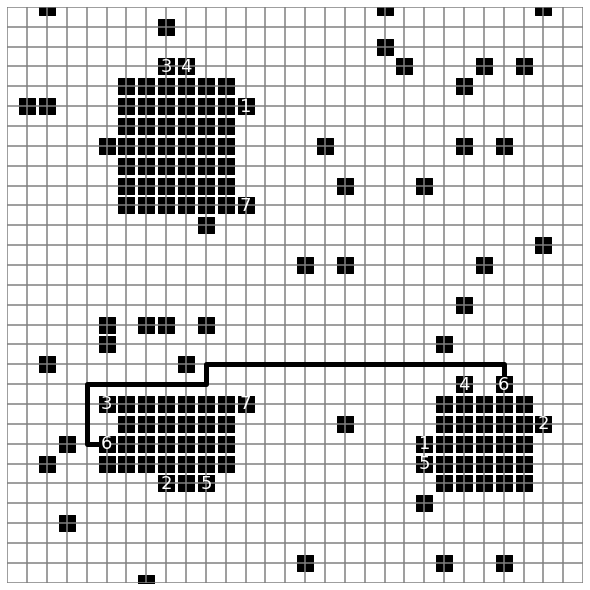

In [3]:
from astar import Astar

from MCTS_CREnv_v0 import MCTS_CREnv

env_mcts = MCTS_CREnv(board_path="./board_II4.csv")
# env_mcts.reset(pin_idx=7)
result = env_mcts.find_shortest_path(7)
# result = env_mcts.short_net_path[7]
print(result)

paths_x, paths_y = paths_to_xys([result])
# board = np.absolute(np.genfromtxt("./board_II4.csv", delimiter=','))
board = env_mcts.board

draw_board(paths_x, paths_y, board, "test.jpg")
# print(start, end)
# # print(board)
# print(result)


In [9]:
def prob_DFS(state, model, deterministic=False):
    
    DFS_state = state
    pair_index = state.pairs_idx
    
    states_queue = [DFS_state]
    path = [DFS_state.head]
    
    while DFS_state.pairs_idx==pair_index:
        
        obs_vec = np.expand_dims(DFS_state.board_embedding(), axis=0)
        obs_vis = None
        mask = DFS_state.compute_mask()
        # print(mask, len(states_queue))
        if not all(mask==0):
            if deterministic:
                probs = model.p_all({"vec_obs": obs_vec, "vis_obs": obs_vis})[0]
                new_dist = probs.numpy()*mask
                # print(new_dist)
                if sum(new_dist)==0:
                    new_dist = mask
                new_dist = new_dist/sum(new_dist)
                action = np.argmax(new_dist)
            else:
                action, _, _ = model.get_action_logp_value({"vec_obs": obs_vec, "vis_obs": obs_vis}, mask=mask)
            DFS_state = DFS_state.takeAction(action)
            states_queue.append(DFS_state)
            path.append(DFS_state.head)
        elif len(states_queue)>1:
            pop_state = states_queue.pop()
            pop_state.board[pop_state.head] = 1
            DFS_state = states_queue[-1]
            DFS_state.board = pop_state.board
            # do not ahve to do this for now, but for later try of CNN
            DFS_state.board[DFS_state.head] = DFS_state.head_value
            path.pop()
        else:
            break

    # path.pop()
    return path
        
        

In [77]:
def prune_paths(paths_array, state):

    directions = [(-1, 0), (0, 1), (1, 0), (0, -1)]
    # # pruning path within 1-unit distance
    # length = len(paths_array)

    # i = 0
    # while i < length-1:
    #     current_node = paths_array[i]
    #     for j in range(i+2, length):
    #         later_node = paths_array[j]
    #         diff = sum(np.absolute(current_node-later_node))
    #         if diff == 1:
    #             paths_array = np.delete(paths_array, list(range(i+1, j)), axis=0)
    #             length = len(paths_array)
    #             break
    #     i += 1

    # pruning path considering 3 directions
    length = len(paths_array)

    i = 1
    while i < length-1:
        current_node = paths_array[i]
        # checking current node if it is a turning node
        pre_direction = current_node - paths_array[i-1]
        post_direction = paths_array[i+1] - current_node
        if tuple(pre_direction)==tuple(post_direction):
            check_directions = [np.array(d) for d in directions if 0 not in np.array(d)+pre_direction]
        else:
            check_directions = [pre_direction, -post_direction]

        for cd in check_directions:
            paths_array = examine_one_direction(paths_array, i, cd, state)
        
        i += 1

    return paths_array


def examine_one_direction(path, node_id, checkD, env_state):

    node = path[node_id]
    board2D = env_state.board
    target_node = env_state.finish[env_state.pairs_idx]
    node = np.array(node)+np.array(checkD)
    board_shape = np.array(board2D.shape)

    explore_nodes = []
    while np.array(node<board_shape).all() and np.array(node>=0).all():
        if board2D[tuple(node.astype(int))]==0 or tuple(node)==target_node:
            check_node_in = [np.array_equal(node,pn) for pn in path[node_id:]]
            if True in check_node_in:
                print(node, path)
                current_idx = check_node_in.index(True)
                path = path[:node_id+1]+explore_nodes+path[node_id+current_idx:]
                break
            else:
                explore_nodes.append(node)
                node += np.array(checkD) 
        else:
            break
    return path



In [52]:
a = [np.array([1,1]), np.array([2,2])]
b = np.array([1,2])
c = np.ones((3,5))
print([np.array_equal(b,pn) for pn in a].index(True))

ValueError: True is not in list

[ 5. 22.] [array([ 5., 18.]), array([ 5., 19.]), array([ 5., 20.]), array([ 4., 20.]), array([ 4., 21.]), array([ 3., 21.]), array([ 3., 22.]), array([ 4., 22.]), array([ 5., 22.]), array([ 6., 22.]), array([ 6., 23.]), array([ 6., 23.]), array([ 5., 23.]), array([ 4., 23.]), array([ 3., 23.]), array([ 3., 24.]), array([ 2., 24.]), array([ 2., 25.]), array([ 2., 26.]), array([ 2., 27.]), array([ 1., 27.]), array([ 0., 27.]), array([ 0., 26.]), array([ 0., 25.]), array([ 0., 24.]), array([ 0., 23.]), array([ 0., 22.]), array([ 0., 21.]), array([ 0., 20.]), array([ 1., 20.]), array([ 1., 19.]), array([ 2., 19.]), array([ 3., 19.]), array([ 3., 18.]), array([ 4., 18.]), array([ 4., 17.]), array([ 5., 17.]), array([ 5., 16.]), array([ 4., 16.]), array([ 4., 15.]), array([ 5., 15.]), array([ 5., 14.]), array([ 5., 13.]), array([ 4., 13.]), array([ 4., 14.]), array([ 3., 14.]), array([ 2., 14.]), array([ 2., 13.]), array([ 1., 13.]), array([ 0., 13.]), array([ 0., 12.]), array([ 0., 11.]), a

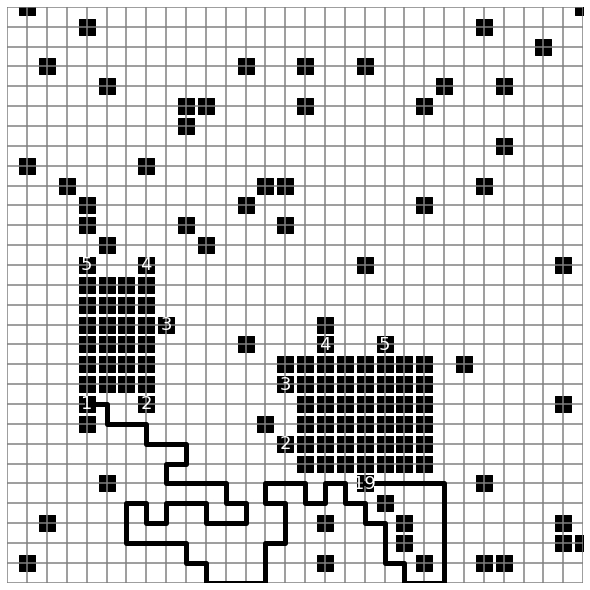

In [78]:
# read board and paths

from MCTS_CREnv_v0 import MCTS_CREnv
import numpy as np

board_file = "./board0.csv"
path_file = "board0_path.csv"

env = MCTS_CREnv(board_path=board_file)
env.reset()

paths = np.genfromtxt(path_file, delimiter=',')
sep_paths = []
path_tem = []
for p in paths:
    if -1 in p:
        sep_paths.append(path_tem)
        path_tem = []
    else:
        path_tem.append(p)

new_path = prune_paths(sep_paths[0], env)
# new_path = sep_paths[0]
# print(new_path)
paths_x, paths_y = paths_to_xys([new_path])
# board = np.absolute(np.genfromtxt("./board_II4.csv", delimiter=','))
board = env.board

draw_board(paths_x, paths_y, board, "test.jpg")

# print(sep_paths)